<a href="https://colab.research.google.com/github/CallMeL/Medical-Image-Segmentation/blob/main/%E6%88%91%E8%A7%89%E5%BE%97%E8%83%BD%E6%88%90%E5%8A%9Funetpp%E4%BD%86%E6%98%AF%E6%98%AFts%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[参考reference](https://github.com/sauravmishra1710/UNet-Plus-Plus---Brain-Tumor-Segmentation)

下一步https://github.com/CallMeL/unet-pytorch

In [1]:
!git clone https://github.com/sauravmishra1710/UNet-Plus-Plus---Brain-Tumor-Segmentation.git

Cloning into 'UNet-Plus-Plus---Brain-Tumor-Segmentation'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 130 (delta 56), reused 88 (delta 25), pack-reused 0
Receiving objects: 100% (130/130), 35.95 MiB | 13.90 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
!cd /content/UNet-Plus-Plus---Brain-Tumor-Segmentation

## tensorflow

### ImageDataGen

In [9]:
import os
import sys
import random
import numpy as np
import cv2
import gc
import tensorflow as tf
import matplotlib.pyplot as plt

class ImageDataGen(tf.keras.utils.Sequence):
    
    """
    The custom data generator class generates and feeds data to
    the model dynamically in batches during the training phase.
    
    This generator generates batched of data for the dataset available @
    Find the nuclei in divergent images to advance medical discovery -
    https://www.kaggle.com/c/data-science-bowl-2018
    
    **
    tf.keras.utils.Sequence is the root class for 
    Custom Data Generators.
    **
    
    Args:
        image_ids: the ids of the image.
        img_path: the full path of the image directory.
        mask_path: the full path of the mask directory.
        batch_size: no. of images to be included in a batch feed. Default is set to 32.
        image_size: size of the image. Default is set to 512 as per the data available.
        
    Ref: https://dzlab.github.io/dltips/en/keras/data-generator/
    
    """
    def __init__(self, image_ids, img_path, mask_path, batch_size = 32, image_size = 512, shuffle = True):
        
        self.ids = image_ids
        self.img_path = img_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __load__(self, item):
        
        """
        loads the specified image.
        
        """
        
        full_image_path = os.path.join(self.img_path, item)
        full_mask_path = os.path.join(self.mask_path, item)
        
        # load the images
        image = cv2.imread(full_image_path, 0)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        # load the masks
        mask = cv2.imread(full_mask_path, 0)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        
        # normalize the mask and the image. 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        
        """
        Returns a single batch of data.
        
        Args:
            index: the batch index.
        
        """
        
        # edge case scenario where there are still some items left
        # after segregatings the images into batches of size batch_size.
        # the items left out will form one batch at the end.
        if(index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size
        
        # group the items into a batch.
        batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        
        image = []
        mask  = []
        
        # load the items in the current batch
        for item in batch:
            img, msk = self.__load__(item)
            image.append(img)
            mask.append(msk)
        
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        
        """
        optional method to run some logic at the end of each epoch: e.g. reshuffling
        
        """
        
        if self.shuffle:
            random.shuffle(self.ids)
            
        gc.collect()
    
    def __len__(self):
        
        """
        Returns the number of batches
        """
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    

### UNetPlusPlus

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, concatenate, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

class UNetPlusPlus():
    
    """ 
    Unet++ Model design.
    
    This module consumes the Unet utilities framework moule and designs the Unet network.
    It consists of a contracting path and an expansive path. Both these paths are joined 
    by a bottleneck block.
    
    The different blocks involved in the design of the network can be referenced @ 
    U-Net: Convolutional Networks for Biomedical Image Segmentation
    
    Reference:
        [1] UNet++: A Nested U-Net Architecture for Medical Image Segmentation.
            https://arxiv.org/abs/1807.10165
            
        [2] https://paperswithcode.com/paper/unet-a-nested-u-net-architecture-for-medical
    """
    
    def __init__(self, input_shape = (512, 512, 1), filters = [32, 64, 128, 256, 512], nb_classes = 1, deep_supervision = False):
        
        """
        Initialize the Unet framework and the model parameters - input_shape, 
        filters and padding type. 
        
        Args:
            input_shape (tuple): A shape tuple (integers), not including the batch size.
                                 Default value is (512, 512, 1).
                                 
            filters (array of integers: a collection of filters denoting the number of components to be used at each blocks along the 
                        contracting and expansive paths. The original paper implementation for number of filters along the 
                        contracting and expansive paths are [32, 64, 128, 256, 512]. (as per paper: k = 32 × 2^i).
                        
            nb_classes (Integer): the dimensionality (no. of filters) of the output space .
                        (i.e. the number of output filters in the convolution).

            deep_supervision (boolean): A flag that toggles between the 2 different training modes -
                                        1) the ACCURATE mode - where the outputs from all segmentation 
                                           branches are averaged., 
                                        2) the FAST mode - wherein the final segmentation map is selected from 
                                           only one of the segmentation branches.
                                        Default vaue - False
            
        **Remarks: The default values are as per the implementation in the original paper @ https://arxiv.org/pdf/1505.04597
         
        """

        self.__input_shape = input_shape
        self.__filters = filters
        self.__nb_classes = nb_classes
        self.__deep_supervision = deep_supervision
        self.__smooth = 1. # Used to prevent the denominator from 0 when computing the DICE coefficient.
    
    def BuildNetwork(self):

        """
        Creates the UNet++ Netwrork for biomedical image segmentation.

        Args:
            None
            
        Returns:
            model: the neural network model representing the UNet++ model architechture.

        """

        input_img = Input(shape = self.__input_shape, name = 'InputLayer')

        conv00 = self.__InsertConvolutionBlock(input_img, block_level = '00', filters = self.__filters[0])
        pool0 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool0')(conv00)

        conv10 = self.__InsertConvolutionBlock(pool0, block_level = '10', filters = self.__filters[1])
        pool1 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool1')(conv10)

        up01 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding='same', name='upsample01')(conv10)
        conv01 = concatenate([up01, conv00], name='concat01')
        conv01 = self.__InsertConvolutionBlock(conv01, block_level = '01', filters = self.__filters[0])

        conv20 = self.__InsertConvolutionBlock(pool1, block_level = '20', filters = self.__filters[2])
        pool2 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool2')(conv20)

        up11 = Conv2DTranspose(filters = self.__filters[1], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample11')(conv20)
        conv11 = concatenate([up11, conv10], name = 'concat11')
        conv11 = self.__InsertSkipPathway(conv11, block_level = '11', filters = self.__filters[1])

        up02 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding='same', name='upsample02')(conv11)
        conv02 = concatenate([up02, conv00, conv01], name = 'concat02')
        conv02 = self.__InsertConvolutionBlock(conv02, block_level = '02', filters = self.__filters[0])

        conv30 = self.__InsertConvolutionBlock(pool2, block_level = '30', filters = self.__filters[3])
        pool3 = MaxPooling2D(pool_size = 2, strides = 2, name = 'pool3')(conv30)

        up21 = Conv2DTranspose(filters = self.__filters[2], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample21')(conv30)
        conv21 = concatenate([up21, conv20], name='concat21')

        conv21 = self.__InsertConvolutionBlock(conv21, block_level='21', filters = self.__filters[2])

        up12 = Conv2DTranspose(filters = self.__filters[1], kernel_size = 2, strides = 2, padding='same', name = 'upsample12')(conv21)
        conv12 = concatenate([up12, conv10, conv11], name = 'concat12')
        conv12 = self.__InsertSkipPathway(conv12, block_level = '12', filters = self.__filters[1])

        up03 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample03')(conv12)
        conv03 = concatenate([up03, conv00, conv01, conv02], name = 'concat03')
        conv03 = self.__InsertConvolutionBlock(conv03, block_level = '03', filters = self.__filters[0])

        conv40 = self.__InsertConvolutionBlock(pool3, block_level = '40', filters = self.__filters[4])

        up31 = Conv2DTranspose(filters = self.__filters[3], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample31')(conv40)
        conv31 = concatenate([up31, conv30], name = 'concat31')
        conv31 = self.__InsertSkipPathway(conv31, block_level = '31', filters=self.__filters[3])

        up22 = Conv2DTranspose(filters = self.__filters[2], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample22')(conv31)
        conv22 = concatenate([up22, conv20, conv21], name = 'concat22')
        conv22 = self.__InsertSkipPathway(conv22, block_level = '22', filters = self.__filters[2])

        up13 = Conv2DTranspose(filters = self.__filters[1], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample13')(conv22)
        conv13 = concatenate([up13, conv10, conv11, conv12], name='concat13')
        conv13 = self.__InsertSkipPathway(conv13, block_level = '13', filters = self.__filters[1])

        up04 = Conv2DTranspose(filters = self.__filters[0], kernel_size = 2, strides = 2, padding = 'same', name = 'upsample04')(conv13)
        conv04 = concatenate([up04, conv00, conv01, conv02, conv03], name = 'concat04')
        conv04 = self.__InsertConvolutionBlock(conv04, block_level = '04', filters = self.__filters[0])

        nested_op_1 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op1')(conv01)

        nested_op_2 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op2')(conv02)

        nested_op_3 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding= 'same', name = 'op3')(conv03)

        nested_op_4 = Conv2D(filters = self.__nb_classes, kernel_size = 1, activation = tf.nn.sigmoid, 
                                  padding = 'same', name = 'op4')(conv04)

        if self.__deep_supervision:
            output = [nested_op_1, nested_op_2, nested_op_3, nested_op_4]
        else:
            output = [nested_op_4]

        model = Model(inputs = input_img, outputs = output, name = "UNetPP")

        return model

    def __InsertSkipPathway(self, input_tensor, block_level, filters, kernel_size = 3):

        """
        Inserts a convolution block along the skip pathways.

        Args:
            input_tensor: The input that would go into the convolutional block.
            block_level: the level of the current block.
            filters: the dimensionality (no. of filters) of the output space 
                        (i.e. the number of output filters in the convolution).
            kernel_size: the size of the convolving window. Default value is 3.
                         All convolutional layers along a skip pathway (X(i, j) )
                         use k kernels of size 3×3.

        Returns:
            x: The 2D convolution output.

        """
        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_1')(input_tensor)

        x = Dropout(rate = 0.5, name = 'X' + block_level + '_')(x)

        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_2')(x)

        x = Dropout(rate = 0.5, name = 'X' + block_level)(x)

        return x

    def __InsertConvolutionBlock(self, input_tensor, block_level, filters, kernel_size = 3):

        """
        Inserts a convolution block along the contracting 
        and expanding paths of the network.

        Args:
            input_tensor: The input that would go into the convolutional block.
            block_level: the level of the current block.
            filters: the dimensionality (no. of filters) of the output space 
                        (i.e. the number of output filters in the convolution).
            kernel_size: the size of the convolving window. Default value is 3.            

        Returns:
            x: The 2D convolution output.

        """

        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_1')(input_tensor)

        x = Dropout(rate = 0.5, name = 'X' + block_level + '_')(x)

        x = Conv2D(filters = filters, kernel_size = kernel_size, activation = tf.nn.relu, 
                   padding = 'same', name = 'conv' + block_level + '_2')(x)

        x = Dropout(rate = 0.5, name = 'X' + block_level)(x)

        return x
    
    # WARNING:tensorflow:AutoGraph could not transform <bound method UNetPlusPlus.__dice_coef_loss of 
    # <UNetPP.UNetPlusPlus object at 0x000001A33B0D8198>> and will run it as-is.
    # Cause: mangled names are not yet supported. To silence this warning, decorate the function with 
    # @tf.autograph.experimental.do_not_convert
    @tf.autograph.experimental.do_not_convert
    def __dice_coef(self, y_true, y_pred):
        
        """
        computes the dice loss. loss function for image segmentation 
        tasks is based on the Dice coefficient, which is essentially 
        a measure of overlap between two samples. This measure ranges 
        from 0 to 1 where a Dice coefficient of 1 denotes perfect and 
        complete overlap.
        
        Args:
            y_true: the true value of the image mask.
            y_pred: the predicted value of the image mask.
        
        Returns:
            dice_val: the dice loss value
            
        Ref:
            https://www.programmersought.com/article/11533881518/
            
        """
        
        y_true_f = K.flatten(y_true) # Extend y_true to one dimension.
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + self.__smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + self.__smooth)
    
    @tf.autograph.experimental.do_not_convert
    def __dice_coef_loss(self, y_true, y_pred):
        
        """
        computes the dice loss. loss function for image segmentation 
        tasks is based on the Dice coefficient, which is essentially 
        a measure of overlap between two samples. This measure ranges 
        from 0 to 1 where a Dice coefficient of 1 denotes perfect and 
        complete overlap.
        
        Args:
            y_true: the true value of the image mask.
            y_pred: the predicted value of the image mask.
        
        Returns:
            dice_val: the dice loss value
            
        Ref:
            https://www.programmersought.com/article/11533881518/
            
        """
        
        return 1. - self.__dice_coef(y_true, y_pred)
    
    
    @tf.autograph.experimental.do_not_convert
    def __iou_loss_core(self, y_true, y_pred):
        
        """
        computes the intersection over union metric. 
        Intersection over Union is an evaluation metric 
        used to measure the accuracy of an object/mask detected. 
        
        Args:
            y_true: the true value of the image mask.
            y_pred: the predicted value of the image mask.
            smooth: 
        
        Returns:
            iou: the iou coefficient.
            
        """
        intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
        union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
        iou = (intersection + self.__smooth) / ( union + self.__smooth)
        
        return iou
    
    def CompileAndSummarizeModel(self, model, optimizer = "adam", loss = "binary_crossentropy"):

        """
        Compiles and displays the model summary of the Unet++ model.

        Args:
            model: The keras instance of the Unet++ model.
            optimizer: model optimizer. Default is the adam optimizer.
            loss: the loss function. Default is the binary cross entropy loss.

        Return:
            None

        """
        model.compile(optimizer = optimizer, 
                      loss = self.__dice_coef_loss, 
                      metrics = ['acc', self.__iou_loss_core])
        
        model.summary()

    def plotModel(self, model, to_file = 'unetpp.png', show_shapes = True, dpi = 96):

        """
        Saves the Unet++ model plot/figure to a file.

        Args:
            model: The keras instance of the Unet++ model.
            to_file: the file name to save the model. Default name - 'unet.png'.
            show_shapes: whether to display shape information. Default = True.
            dpi: dots per inch. Default value is 96.

        Return:
            None

        """

        tf.keras.utils.plot_model(model, to_file = to_file, show_shapes = show_shapes, dpi = dpi)

### ImageDataExtractor
注意：这个下面有个self.download的部分被注释掉了，第一次跑还是加上，总之就是先下载zip，然后把mat解压，然后调用readmat和saveimg变成image和mask

attention: the `self.download` part in the next cell has been commented, if you run it for the first time, do remember to uncomment them, or simply copy the original code in the `/content/drive/MyDrive/UNet-Plus-Plus---Brain-Tumor-Segmentation/ImageDataExtractor.py` file( important: change the '\*.mat' to '/*.mat. or you can't convert image in colab)




In [1]:
import os
import stat
import h5py
import glob
import shutil
import zipfile
import requests
import numpy as np
from pathlib import Path
from tqdm import notebook
import matplotlib.image as mpimg
from os.path import dirname as up

class ImageDataExtractor():
    
    """
    A utility class to download, organize and read the *.mat files that are saved in the matlab format, 
    extract the image data that is stored as part of the file.
    The image and the corresponding tumor mask are stored as part of the fields 
    cjdata.image & cjdata.tumorMask.
    
    """
    
    def __init__(self, RemoveTemporaryFiles = True):
        
        """
        A utility class to download, organize and read the *.mat files that are saved in the matlab format, 
        extract the image data that is stored as part of the file.
        The image and the corresponding tumor mask are stored as part of the fields 
        cjdata.image & cjdata.tumorMask.
        
        Args:
            RemoveTemporaryFiles (boolean): A flag to check if the downloaded files have 
                                            to be retained or deleted after the image and masks
                                            have been extracted. Default Value - True (delete the
                                            temp files)

        """
        
        self.__DATA = '/content/drive/MyDrive/UNet-Plus-Plus/data'
        self.__MAT_DATA_PATH = os.path.join(self.__DATA, 'matData')
        self.__IMG_DATA_PATH = os.path.join(self.__DATA, 'imgData', 'img')
        self.__MASK_DATA_PATH = os.path.join(self.__DATA, 'imgData', 'mask')
        self.__TEMP_DOWNLOAD_PATH = os.path.join(self.__DATA, 'temp', 'download')
        self.__ZIP_FILE = os.path.join(self.__TEMP_DOWNLOAD_PATH, '1512427.zip')
        self.__TEMP_ZIP_FILE = os.path.join(os.path.split(self.__ZIP_FILE)[0], 
                                            os.path.splitext(os.path.basename(self.__ZIP_FILE))[0] + '__.zip')
        self.__TEMP_UNZIP_PATH = os.path.join(up(self.__TEMP_DOWNLOAD_PATH), 'unzip')
        self.__DATA_URL = 'https://ndownloader.figshare.com/articles/1512427/versions/5'
        self.__DATA_README_PATH = os.path.join(self.__DATA, 'README.txt')
        self.__REMOVE_TEMP_FILES = RemoveTemporaryFiles
        
        # if the master 'data' folder is not present
        # create the directory and proceed.
        if not (os.path.isdir(self.__DATA)):
            self.__create_dir(self.__DATA)
        
        # if the temp download folder is not present, create it
        if not (os.path.isdir(self.__TEMP_DOWNLOAD_PATH)):
            self.__create_dir(self.__TEMP_DOWNLOAD_PATH)
        
        # if the temp data unzip folder is not present, create it
        if not (os.path.isdir(self.__TEMP_UNZIP_PATH)):
            self.__create_dir(self.__TEMP_UNZIP_PATH)
        
    
    def __readMatData(self, filePath: str):
    
        """ 
        Reads the mat file and returns the image & mask array.

        Args:
            filePath(str): Path of the file to be read.

        Returns:
            data(dict): The array of the image and the corresponding mask 
                        in the dictionary format.
                        'image': The numpy array for image.
                        'mask' : The numpy array for the corresponding mask.

        """

        file = h5py.File(filePath, 'r')

        imgData = dict()
        
        # the image and the corresponding mask are stored as part of the fields - 
        # cjdata.image & cjdata.tumorMask
        imgData['image'] = np.array(file.get('cjdata/image'))
        imgData['mask'] = np.array(file.get('cjdata/tumorMask'))

        return imgData

    def __create_dir(self, target_dir):

        """
        Creates folder if there is no folder in the 
        specified directory path.

        Args: 
            target_folder(str): path of the folder which needs to be created.

        Returns: 
            None

        """
        
        # create the directory/folder if it is not already 
        # present in the specified path.
        if not (os.path.isdir(target_dir)):
            os.makedirs(target_dir, exist_ok = True)

    def __save_image_data(self, filename, data, imgFormat = 'png'):

        """ 
        Saves the image & mask array in png format.

        Args:
            filename(str): Name of the file without the extension.
            data(dict): The array of the image and the corresponding mask 
                        in the dictionary format.
                        'image': The numpy array for image.
                        'mask' : The numpy array for the corresponding mask.

        Returns: 
            None

        """

        img_path = os.path.join(self.__IMG_DATA_PATH, filename + '.' + imgFormat)
        mask_path = os.path.join(self.__MASK_DATA_PATH, filename + '.' + imgFormat)
        
        mpimg.imsave(img_path, data['image'], cmap = 'gray', format = imgFormat)
        mpimg.imsave(mask_path, data['mask'], cmap = 'gray', format = imgFormat)
        
    def downloadAndExtractImages(self):
        
        """ 
        Extracts the image data from the corresponding .mat files and
        saves the extracted image & mask array in png format.

        Args:
            None

        Returns: 
            None

        """ 
        
        # check if the data is already extracted. check the relevant directories are created or not.
        if os.path.isdir(self.__MAT_DATA_PATH) and os.path.isdir(self.__IMG_DATA_PATH) and os.path.isdir(self.__MASK_DATA_PATH):
            print(">>> Data already downloaded. Check the following directoies")
            print("-----------------------------------------------------------")
            print(">>> Mat files located @ " + "'" + self.__MAT_DATA_PATH + "'")
            print(">>> Image files located @ " + "'" + self.__IMG_DATA_PATH + "'")
            print(">>> Mask files located @ " + "'" + self.__MASK_DATA_PATH + "'")
            print(">>> Data ReadMe located @ " + "'" + self.__DATA_README_PATH + "'")
            #return self.__MAT_DATA_PATH, self.__IMG_DATA_PATH, self.__MASK_DATA_PATH, self.__DATA_README_PATH
        
        # download & unzip the data if not present.
        """
        if not (os.path.isdir(self.__MAT_DATA_PATH)):
            self.__downloadData()
            #!!!!!!
            self.__upzipData()
          """
        # extract the image amd the corresponding mask data.
        #if (os.path.isdir(self.__IMG_DATA_PATH) and os.path.isdir(self.__MASK_DATA_PATH)):
            # create the directory/folder if it is not already 
            # present in the specified path.
        """
        self.__create_dir(self.__IMG_DATA_PATH)
        self.__create_dir(self.__MASK_DATA_PATH)
        """
            # extract the .mat files into a list.
        files = glob.glob(self.__MAT_DATA_PATH + '/*.mat')

        print(">>> Extracting images and masks...")

        for idx in  notebook.tqdm(range(len(files))):
          file = files[idx]

                # extract the filename to be used to save the 
                # image and its mask.
          filename = os.path.splitext(os.path.basename(file))[0]

          data = self.__readMatData(file)
          self.__save_image_data(filename, data)
        print(">>> Data extraction complete...")
        
        # remove the files only if the flag is set
        if self.__REMOVE_TEMP_FILES:
            print(">>> Removing the master zip file...")
            if os.path.isfile(self.__ZIP_FILE):
                os.remove(self.__ZIP_FILE)

            # delete the temp folder @ temp_unzip_path
            if (os.path.isdir(self.__TEMP_UNZIP_PATH)):
                print(">>> Removing the temp folder created for download..." + "'" + self.__TEMP_DOWNLOAD_PATH + "'")
                shutil.rmtree(up(self.__TEMP_DOWNLOAD_PATH))
        
        print("\n>>> Data loaded into the following directoies")
        print("-----------------------------------------------")
        print(">>> Mat files located @ " + "'" + self.__MAT_DATA_PATH + "'")
        print(">>> Image files located @ " + "'" + self.__IMG_DATA_PATH + "'")
        print(">>> Mask files located @ " + "'" + self.__MASK_DATA_PATH + "'")
        print(">>> Data ReadMe located @ " + "'" + self.__DATA_README_PATH + "'")
           
        # return the data directories path to the caller.
        return self.__MAT_DATA_PATH, self.__IMG_DATA_PATH, self.__MASK_DATA_PATH, self.__DATA_README_PATH
         
    def __downloadData(self, chunk_size = 1024):
    
        """ 
        Download the file from the given url.

        Args:
            chunk_size (int):  number of bytes it should read into memory. Default Value is 1024

        Returns: 
            None

        """

        # Delete the incomplete downloads from previous sessions.
        if os.path.isfile(self.__TEMP_ZIP_FILE):
            print('>>> Deleting any incomplete downloaded file from previous session @ ' + self.__TEMP_ZIP_FILE)
            os.remove(self.__TEMP_ZIP_FILE)

        # Download the file
        print(">>> Downloading data to - " + "'" + self.__TEMP_ZIP_FILE + "'")
        response = requests.get(self.__DATA_URL, stream = True)
        with open(self.__TEMP_ZIP_FILE, "wb") as handle:

            total_size = round(int(response.headers['Content-Length']), 3)
            pbar = notebook.tqdm(unit = "B", total = total_size)
            for chunk in response.iter_content(chunk_size = chunk_size):
                if chunk:  # filter out keep-alive new chunks
                    handle.write(chunk)
                    pbar.update(len(chunk))

        # Rename the file to the correct name 
        # once download is complete.
        os.rename(self.__TEMP_ZIP_FILE, self.__ZIP_FILE)
        print(">>> Download Complete...")
        
    def __upzipData(self):
        
        """
        extracts the downloaded data, data readme file
        and prepares to read the images and masks.
        
        Args:
            None
        
        Return:
            None
        
        """
    
        self.__create_dir(self.__TEMP_UNZIP_PATH)

        # extract the master zipped file.
        print(">>> Extracting Master Folder...")
        for idx in  notebook.tqdm(range(1)):
            with zipfile.ZipFile(self.__ZIP_FILE, "r") as _zip:
                _zip.extractall(self.__TEMP_UNZIP_PATH)

        print(">>> Extracting *.mat files...")
        files = glob.glob(self.__TEMP_UNZIP_PATH + '\*.zip')

        self.__create_dir(self.__MAT_DATA_PATH)

        # exract the mat files from the respective zipped files.
        for idx in  notebook.tqdm(range(len(files))):
                with zipfile.ZipFile(files[idx], "r") as _zip:
                    _zip.extractall(self.__MAT_DATA_PATH)
        
        # copy the data readme file to the data folder.
        readMeDestination = self.__DATA
        readMeFileName = os.path.split('data\\temp\\unzip\\README.txt')[1]
        
        # set the data readme path to return to the caller.
        self.__DATA_README_PATH = os.path.join(readMeDestination, readMeFileName)
        print(">>> Copying the data ReadMe file to - " + "'\\" + self.__DATA_README_PATH + "'")
        readMe = glob.glob(self.__TEMP_UNZIP_PATH + '\*.txt')
        
        # copy the readme file to the data folder.
        #shutil.copy2(readMe[0], readMeDestination)
        
        print(">>> Data unzipped successfully to " + "'" + self.__MAT_DATA_PATH + "'")


In [5]:
#!unzip '/content/Untitled Folder/1512427.zip'

#### 变量设置

In [34]:
image_size = 128
image_channels = 1
epochs = 30
batch_size = 64

# there are a total of 3064 images.
# so fixing 2900 of data available for training set
# 200 for validation set and 64 for test set.
validation_data_size = 200
test_data_size = 64
train_data_size = 2800
train_steps = 10
valid_steps = 2
MAT_DATA_PATH = '/content/drive/MyDrive/UNet-Plus-Plus/data/matData'
IMG_DATA_PATH = '/content/drive/MyDrive/UNet-Plus-Plus/data/imgData/img'
MASK_DATA_PATH = '/content/drive/MyDrive/UNet-Plus-Plus/data/imgData/mask'

#### 第一次跑

In [ ]:
dataExtractor = ImageDataExtractor(RemoveTemporaryFiles = True)
MAT_DATA_PATH, IMG_DATA_PATH, MASK_DATA_PATH, DATA_README_PATH = dataExtractor.downloadAndExtractImages()

In [ ]:
MAT_DATA_PATH, IMG_DATA_PATH, MASK_DATA_PATH, DATA_README_PATH

In [ ]:
!unzip /content/drive/MyDrive/UNet-Plus-Plus---Brain-Tumor-Segmentation/data/temp/download/1512427.zip

In [ ]:
!unzip /content/brainTumorDataPublic_1-766.zip -d /content/drive/MyDrive/UNet-Plus-Plus---Brain-Tumor-Segmentation/data/temp/unzip

In [ ]:
!unzip /content/brainTumorDataPublic_2299-3064.zip -d /content/drive/MyDrive/UNet-Plus-Plus---Brain-Tumor-Segmentation/data/temp/unzip
!unzip /content/brainTumorDataPublic_767-1532.zip -d /content/drive/MyDrive/UNet-Plus-Plus---Brain-Tumor-Segmentation/data/temp/unzip
!unzip /content/brainTumorDataPublic_1533-2298.zip -d /content/drive/MyDrive/UNet-Plus-Plus---Brain-Tumor-Segmentation/data/temp/unzip

### VisualizeImageAndMask

In [5]:
def VisualizeImageAndMask(image, mask, prediction_img = None):
    
    """
    
    Displays the image, mask and the predicted mask
    of the input image.
    
    Args:
        image: the original image.
        mask: the given mask of the image.
        prediction_img: the predicted mask of the image.
        
    Return:
        None
        
    """
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image, cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nImage')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(mask, cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')
    
    if prediction_img is not None:
        #prediction_img = prediction_img * 255
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')
    
def setTitleAndRemoveTicks(axes, title):
    
    """
    Sets the sub-plot title and removes the 
    x & y ticks on the respective axes.
    
    Args:
        axes: the subplot.
        title: title of the subplot.
        
    Return:
        None
        
    """
    
    # set plot title
    axes.title.set_text(title)
    
    # remove the ticks
    axes.set_xticks([])
    axes.set_yticks([])

### environment test

In [6]:
# get the ids of the images.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames). We need the directory names here.
# IMG_DATA_PATH = 'data\\imgData\\img'
# MASK_DATA_PATH = 'data\\imgData\\mask'
image_ids = next(os.walk(IMG_DATA_PATH))[2]
np.random.shuffle(image_ids)

# partition the data into train, test and validation sets.
testing_data_ids = image_ids[:test_data_size]
validation_data_ids = image_ids[:validation_data_size]
training_data_ids = image_ids[:train_data_size]

In [7]:
temp_data_generator = ImageDataGen(image_ids = training_data_ids,
                                   img_path = IMG_DATA_PATH, 
                                   mask_path = MASK_DATA_PATH,
                                   batch_size = batch_size, 
                                   image_size = image_size)

# get one batch of data
images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)

Batch Dimension Details: (64, 128, 128) (64, 128, 128)


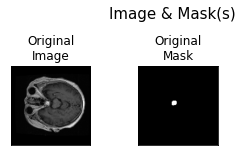

In [12]:
VisualizeImageAndMask(image = images[1], mask = masks[1])

In [11]:
temp_data_generator = None

In [22]:
# Initialize the Unet++ with the default parameters. 
# The default params are the one that were used in the original paper.
# Input shape - (512, 512, 1), 
# filters [32, 64, 128, 256, 512].
UNetPP = UNetPlusPlus(input_shape = (128, 128, 1), deep_supervision = False)

# call the build netowrk API to build the network.
model = UNetPP.BuildNetwork()

In [23]:
# compile & summarize the model
if model is not None:
    UNetPP.CompileAndSummarizeModel(model = model)

Model: "UNetPP"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputLayer (InputLayer)        [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv00_1 (Conv2D)              (None, 128, 128, 32  320         ['InputLayer[0][0]']             
                                )                                                                 
                                                                                                  
 X00_ (Dropout)                 (None, 128, 128, 32  0           ['conv00_1[0][0]']               
                                )                                                            

### train

In [35]:
train_gen = ImageDataGen(image_ids = training_data_ids,
                         img_path = IMG_DATA_PATH, 
                         mask_path = MASK_DATA_PATH, 
                         image_size = image_size, 
                         batch_size = batch_size)

valid_gen = ImageDataGen(image_ids = validation_data_ids, 
                         img_path = IMG_DATA_PATH, 
                         mask_path = MASK_DATA_PATH,
                         image_size = image_size, 
                         batch_size = batch_size)

test_gen = ImageDataGen(image_ids = testing_data_ids, 
                        img_path = IMG_DATA_PATH, 
                        mask_path = MASK_DATA_PATH,
                        image_size = image_size, 
                        batch_size = batch_size)

#train_steps = len(training_data_ids)//batch_size
#valid_steps = len(validation_data_ids)//batch_size
train_steps = 10
valid_steps = 2

In [36]:
train_steps, valid_steps

(10, 2)

In [37]:
model.fit(train_gen, 
          validation_data = valid_gen, 
          steps_per_epoch = train_steps, 
          validation_steps = valid_steps, 
          epochs = 15)

Epoch 1/15
10/10 [==============================] - 75s 8s/step - loss: 0.7961 - acc: 0.9795 - __iou_loss_core: 0.4465 - val_loss: 0.8258 - val_acc: 0.9484 - val___iou_loss_core: 0.3549
Epoch 2/15
10/10 [==============================] - 53s 5s/step - loss: 0.7843 - acc: 0.9813 - __iou_loss_core: 0.4600 - val_loss: 0.7579 - val_acc: 0.9809 - val___iou_loss_core: 0.3907
Epoch 3/15
10/10 [==============================] - 43s 4s/step - loss: 0.7532 - acc: 0.9798 - __iou_loss_core: 0.4880 - val_loss: 0.7392 - val_acc: 0.9809 - val___iou_loss_core: 0.4904
Epoch 4/15
10/10 [==============================] - 33s 3s/step - loss: 0.6987 - acc: 0.9693 - __iou_loss_core: 0.5279 - val_loss: 0.9957 - val_acc: 0.9818 - val___iou_loss_core: 0.8539
Epoch 5/15
10/10 [==============================] - 32s 3s/step - loss: 0.6524 - acc: 0.9777 - __iou_loss_core: 0.5879 - val_loss: 0.9987 - val_acc: 0.9812 - val___iou_loss_core: 0.8582
Epoch 6/15
10/10 [==============================] - 28s 3s/step - loss

### test

In [38]:
model_dir = "models"
model_name = "UNetpp_BrainTumorSegment.h5"

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

model.save_weights(os.path.join(model_dir, model_name))

In [39]:
test_gen = ImageDataGen(image_ids = testing_data_ids, 
                        img_path = IMG_DATA_PATH, 
                        mask_path = MASK_DATA_PATH,
                        image_size = image_size, 
                        batch_size = 32)

In [47]:
test_images, test_masks = test_gen.__getitem__(0)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks

In [48]:
test_images_2, test_masks_2 = test_gen.__getitem__(1)
predicted_masks_2 = model.predict(test_images)

predicted_masks_ = predicted_masks

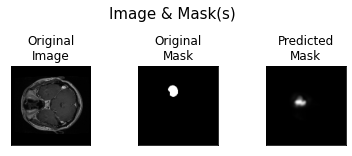

In [50]:
VisualizeImageAndMask(image = test_images_2[4], mask = test_masks_2[4], prediction_img = predicted_masks_[4])